In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation
from models import *
from functools import partial
from jitcdde import jitcdde, y, t, jitcdde_input
import ipywidgets as widgets

In [2]:
class delayed_oscillation(oscillation):
    def __init__(self, model, delay, params, consts, init_cond, calc_all):
        super().__init__(model, params, consts, init_cond, calc_all)
        self.__delay = delay
        dcA2dt, dcSdt = self._oscillation__model()
        dde = jitcdde([dcA2dt, dcSdt])
        dde.compile_C('compiled_dde')

    @property
    def info(self):
        print(
            f'Time-delayed model. The model includes {len(self._oscillation__params)} parameters and {len(self._oscillation__consts)} constants. The species are {self._oscillation__species}. Initial condition: {self._oscillation__init_cond}')
        print(f'Additional information: {self._oscillation__info}')

    def set_delay(self, delay):
        self.__delay = delay
    
    def simulate(self, t=10):
        params_pass = np.hstack((self.__params, self.__consts, self.__delay))

        dde = jitcdde_input('compiled_dde')
        dde.constant_past(self._oscillation__init_cond)
        dde.set_parameters(params_pass)
        dde.restart()
        dde.step_on_discontinuities()

        t_eval = np.linspace(0, t, int(30*t))
        sol = np.array([self.dde.integrate(time) for time in t_eval])

        return (sol, t_eval)
    
    def plot(self, t=10, exp=False, ylim=None):
        i = 0
        color = ['purple', 'b', 'r', 'g']
        if exp == True:
            y0 = [np.array(self._oscillation__exp_data.iloc[0, 1]), np.array(self._oscillation__exp_data.iloc[0, 3])]
            self.dde.constant_past(y0)
            self.dde.step_on_discontinuities()
            sol, t = self.simulate(t=self._oscillation__exp_data.iloc[-1, 0])
            c = self._oscillation__calc_all(sol, self._oscillation__consts, self._oscillation__params)
            fig, axes = plt.subplots(2, 1, figsize=(5, 5))
            for ax in axes:
                ax.plot(
                    self._oscillation__exp_data.iloc[:, 2*i], self._oscillation__exp_data.iloc[:, 2*i+1], label=f'exp-{self._oscillation__species[i]}', color=color[i])
                ax.plot(t, c[i], label=self._oscillation__species[i], linestyle='--', color=color[i])
                if ylim != None:
                    ax.set_ylim(0, ylim)
                ax.set_xlabel('Normalized Time')
                ax.set_ylabel('Normalized Concentration')
                ax.legend(loc="upper right")
                i += 1
                plt.tight_layout()
        else:
            sol, t = self.simulate(t)
            c = self._oscillation__calc_all(sol, self._oscillation__consts, self._oscillation__params)
            fig, axes = plt.subplots(2, 2, figsize=(7, 5))
            for ax, y in zip(axes.flatten(), c):
                ax.plot(t, y, label=self._oscillation__species[i], color=color[i])
                if ylim != None:
                    ax.set_ylim(0, ylim)
                ax.set_xlabel('Normalized Time')
                ax.set_ylabel('Normalized Concentration')
                ax.legend(loc="upper right")
                i += 1
                plt.tight_layout()

        return fig, axes
    
    def interactive_plot(self, t=10, ran=5, step=0.05, exp=False, ylim=None):

        if len(self.__params) == 4:
            def plot_temp(alpha, beta, theta, phi):
                params = [alpha, beta, theta, phi]
                params_old = self.__params
                self.__params = params
                self.plot(t, exp=exp, ylim=ylim)
                self.__params = params_old
        elif len(self.__params) == 5:
            def plot_temp(alpha, beta, theta, phi, K):
                params = [alpha, beta, theta, phi, K]
                params_old = self.__params
                self.__params = params
                self.plot(t, exp=exp, ylim=ylim)
                self.__params = params_old

        params_list = ['alpha', 'beta', 'theta', 'phi', 'K']
        sliders = []

        for i in range(len(self.__params)):
            slider = widgets.FloatSlider(value=self.__params[i], min=max(
                0, self.__params[i]-ran), max=self.__params[i]+ran, step=step, description=params_list[i])
            sliders.append(slider)
        
        if len(self.__params) == 4:
            interactive_widget = widgets.interactive(plot_temp, alpha=sliders[0], beta=sliders[1], theta=sliders[2], phi=sliders[3])
        elif len(self.__params) == 5:
            interactive_widget = widgets.interactive(plot_temp, alpha=sliders[0], beta=sliders[1], theta=sliders[2], phi=sliders[3], K=sliders[4])
        
        display(interactive_widget)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
from symengine import symbols  # Needed for symbolic parameters

# Define symbolic parameters
a, b, tau = symbols("a b tau")  # Now tau is also dynamic

# Define system of equations using symbolic tau
dxdt = -a * y(0) + y(1, t - tau)  # dx/dt = -a*x + y(t - tau)
dydt = -b * y(1) + y(0, t - tau)  # dy/dt = -b*y + x(t - tau)

# Compile JITCDDE equations only once
dde = jitcdde([dxdt, dydt])
dde.constant_past([1.0, 0.0])
dde.step_on_discontinuities()
#dde.compile_C("compiled_system")  # Save compiled equations


Generating, compiling, and loading C code.


SystemExit: error: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2022\\BuildTools\\VC\\Tools\\MSVC\\14.43.34808\\bin\\HostX86\\x64\\cl.exe' failed with exit code 2

c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
from symengine import symbols

In [4]:
def delayed_approx_model_FTC():
    alpha, beta, theta, phi, lam, m, td1, td2 = symbols('alpha beta theta phi lam m td1 td2')
    dxdt = 1 - alpha * y(0) * y(1, t-td2)**m - theta * y(0)
    dydt = alpha/lam * y(0) * y(1, t-td2)**m - beta * y(1, t-td1)**m * y(1) + theta/lam * y(0) - phi * y(1)
    return dxdt, dydt

def calc_all_delayed_approx_model_FTC(sol, consts, *params):
    lam, m = consts
    cA2 = sol[:, 0]
    cS = sol[:, 1]
    cM = cS ** m
    cA = 2 * (1 - cA2) - lam * (cS + cM)
    cO = 1 / (2 * (1 - cA2) - lam * (cS + cM)) ** 2
    return np.array([cA2, cS + cM, cA, cO])

In [5]:
cA2_tol = 14.5
CMC_3a = 1.56
tau = 1.15
df_3a_fig3_NatChem = pd.read_csv('Data_sets/3a_fig3_osc_NatChem_MH.csv')
df_3a_fig3_NatChem['Timea2'] /= tau
df_3a_fig3_NatChem['Times3a'] /= tau
df_3a_fig3_NatChem['s3a'] /= CMC_3a

In [6]:
params = np.array([15, 35.2, 0.65, 18.6])
consts = np.array([0.11, 2])
delay = np.array([0.1, 0.6])
init_cond = [0.9, 0]
delayed_model_fig3 = delayed_oscillation(delayed_approx_model_FTC, delay=delay, params=params, consts=consts, init_cond=init_cond, calc_all=calc_all_delayed_approx_model_FTC)
#delayed_model_fig3.add_exp_data(df_3a_fig3_NatChem)

SystemExit: error: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2022\\BuildTools\\VC\\Tools\\MSVC\\14.43.34808\\bin\\HostX86\\x64\\cl.exe' failed with exit code 2

c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Generating, compiling, and loading C code.
Using default integration parameters.


c:\Users\chem-sedm6967\AppData\Local\anaconda3\envs\jitcdde_clean_env\lib\site-packages\jitcdde\_jitcdde.py:324: UserWarning: The spline already contains points. This will remove them. Be sure that you really want this.
  self.past.constant(state,time)
C:\Users\chem-sedm6967\AppData\Local\Temp\ipykernel_20728\385184256.py:30: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


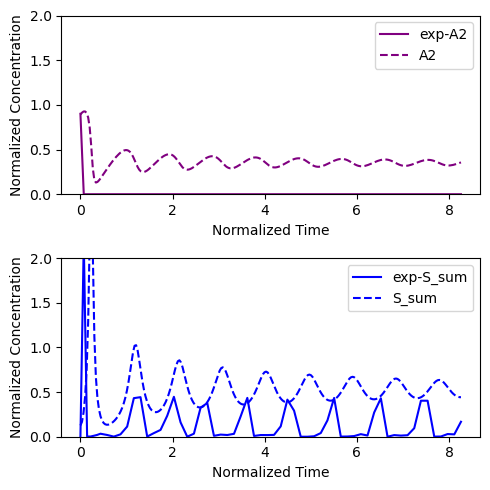

In [ ]:
delayed_model_fig3.set_delay([0.03, 0.04])
fig, axes = delayed_model_fig3.plot(exp=True, ylim=2)

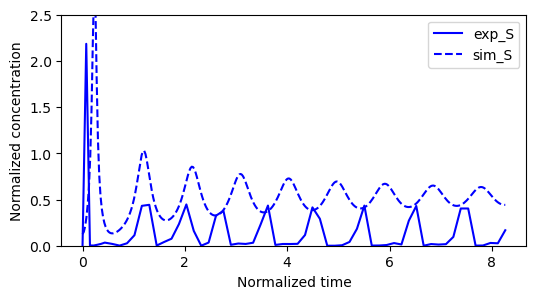

In [ ]:
ax1 = axes[1]
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(ax1.lines[0].get_xdata(), ax1.lines[0].get_ydata(), label='exp_S', color='b')
ax.plot(ax1.lines[1].get_xdata(), ax1.lines[1].get_ydata(), label='sim_S', color='b', linestyle='--')
ax.set_xlabel('Normalized time')
ax.set_ylabel('Normalized concentration')
ax.set_ylim(0, 2.5)
ax.legend()

C:\Users\chem-sedm6967\AppData\Local\Temp\ipykernel_20728\385184256.py:30: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])


(-0.05, 2.0)

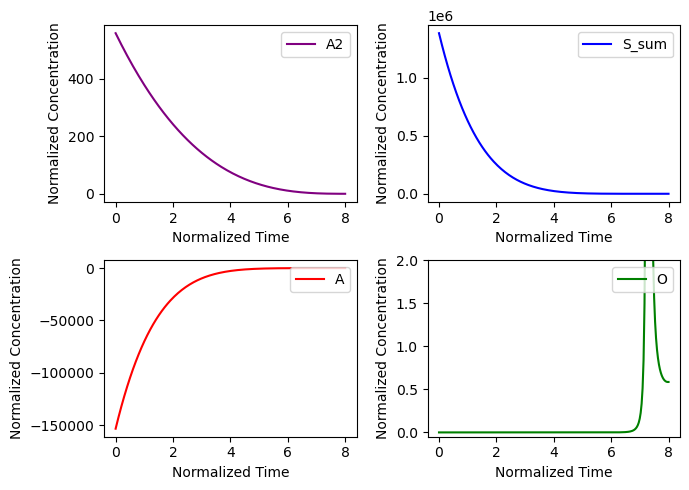

In [ ]:
fig, ax = delayed_model_fig3.plot(t=8)
ax[1][1].set_ylim(-0.05, 2)

In [ ]:
delayed_model_fig3.interactive_plot(exp=True, ran=20, ylim=2)

interactive(children=(FloatSlider(value=15.0, description='alpha', max=35.0, step=0.05), FloatSlider(value=35.…